# Publico categories classifier

In [1]:
from pathlib import Path
import sys

parent = Path().absolute().parents[0].as_posix()

sys.path.insert(0, parent)


In [3]:
import numpy as np
import pandas as pd
import spacy

from nlpiper.core import Compose
from nlpiper.transformers import cleaners
from nlpiper.core import Document

from src.cleaners import TextCleaner
from resources.stopwords import WORDS
import tensorflow as tf

2022-04-27 09:02:03.433369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 09:02:03.433389: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
data_source = pd.read_csv('../data/processed/docs_cleaned_w_categories.csv.gz', compression='gzip')


In [8]:
data_source.columns

Index(['city', 'title', 'content', 'year', 'tstamp', 'link', 'source',
       'link_len', 'check', 'content_p', 'title_p', 'category'],
      dtype='object')

In [9]:
subset_categories = data_source.groupby(['city', 'category' ,'year']).size().reset_index(name='N')
subset_articles = data_source.groupby(['city', 'source' ,'year']).size().reset_index(name='N')



In [10]:
subset_articles

,city,source,year,N
0,Aveiro,expresso.pt,2019,130
1,Aveiro,expresso.pt,2020,177
2,Aveiro,expresso.pt,2021,27
3,Aveiro,jn.pt,2014,4
4,Aveiro,observador.pt,2014,9
...,...,...,...,...
254,Évora,observador.pt,2019,820
255,Évora,observador.pt,2020,635
256,Évora,observador.pt,2021,114
257,Évora,publico.pt,2014,2


In [5]:
data_source.head()

,city,title,content,year,tstamp,link,source,link_len,check,content_p,title_p,category
0,Lisboa,"Oceanário de Lisboa vai ter novo edifício ""tra...","Oceanário de Lisboa vai ter novo edifício ""tra...",2014,20140516081533,https://arquivo.pt/wayback/20140516081533/http...,publico.pt,157,True,oceanario lisboa novo edificio tranquilo anon...,oceanario lisboa novo edificio tranquilo anon...,Economia
1,Lisboa,Câmara de Loures paga mais do dobro do que Lis...,Câmara de Loures paga mais do dobro do que Lis...,2014,20141023080605,https://arquivo.pt/wayback/20141023080605/http...,publico.pt,155,True,camara loures paga dobro lisboa refeicoes esco...,camara loures paga dobro lisboa refeicoes esco...,Politica
2,Lisboa,Deputado Bacelar Gouveia candidata-se à presid...,Deputado Bacelar Gouveia candidata-se à presid...,2014,20141021142620,https://arquivo.pt/wayback/20141021142620/http...,publico.pt,165,True,deputado bacelar gouveia candidatase presidenc...,deputado bacelar gouveia candidatase presidenc...,Politica
3,Lisboa,“Darth Vaders” do blogue 31 da Armada hasteara...,“Darth Vaders” do blogue 31 da Armada hasteara...,2014,20141021111635,https://arquivo.pt/wayback/20141021111635/http...,publico.pt,172,True,darth vaders blogue armada hastearam bandeira...,darth vaders blogue armada hastearam bandeira...,Politica
4,Lisboa,Ordem quer que CML esclareça ranking de arquit...,Ordem quer que CML esclareça ranking de arquit...,2014,20141021180751,https://arquivo.pt/wayback/20141021180751/http...,publico.pt,162,True,ordem quer cml esclareca ranking arquitectos a...,ordem quer cml esclareca ranking arquitectos a...,Justica


In [62]:
d_ = pd.read_csv('../data/raw/publico_scraper.csv.gz', compression='gzip')
d_.head(10)

,city,main_tag,tag,title,sub_title,body,year
0,Lisboa,ciencia,HISTÓRIA,A quinta avenida do século XVI ficava em Lisboa,Dois quadros descobertos em 2009 originaram um...,"No século XVI, a Rua Nova dos Mercadores era u...",2015.0
1,Lisboa,politica,ANTÓNIO COSTA,Costa deixa Câmara de Lisboa para se concentra...,"A cinco meses das eleições legislativas, o sec...",Costa fará uma declaração esta quarta-feira po...,2015.0
2,Lisboa,economia,PRIVATIZAÇÕES,Sociedade Francisco Manuel dos Santos fica com...,Governo concessiona equipamento no Parque das ...,"A concessão do equipamento, um dos mais visita...",2015.0
3,Lisboa,politica,PROVA DOS FACTOS,A dívida da Câmara de Lisboa foi paga pelo Gov...,"Na questão das contas da câmara, tanto Passos ...",A frase\n\nO contexto\nCosta afirmou ter reduz...,2015.0
4,Lisboa,sociedade,LISBOA,Mesquita de Lisboa vandalizada,"Durante a madrugada foi pintado o número ""1143...","“Não nos sentimos ameaçados, mas ficamos trist...",2015.0
5,Lisboa,local,LISBOA,Carros anteriores a 2000 banidos da Baixa de L...,A Câmara de Lisboa diz que a fiscalização vai ...,Aprovada pela Câmara de Lisboa em Outubro de 2...,2015.0
6,Lisboa,local,LISBOA,Arte urbana de Lisboa é cada vez mais uma atra...,"Turistas, sobretudo estrangeiros, são os princ...","""Sabemos pela dinâmica de actividades turístic...",2015.0
7,Lisboa,local,CÂMARA DE LISBOA,PSD quer que PGR investigue Associação de Turi...,Deputado municipal Victor Gonçalves fala em re...,O anúncio de que o partido vai recorrer à PGR ...,2015.0
8,Lisboa,mundo,OPINIÃO,Assistência Mútua sob o Artigo 42.7 do Tratado...,O argumento de que a França está em guerra con...,No rescaldo dos momentosos acontecimentos ocor...,2015.0
9,Lisboa,local,PS,Lisboa é uma das dez câmaras da AML que não pu...,A divulgação das actas e das deliberações nos ...,"Leia os artigos que quiser, até ao fim, sem pu...",2015.0


In [32]:
d_.shape

(13132, 7)

In [33]:
d_.dropna(inplace=True)
d_.shape

(11347, 7)

In [41]:
df = d_.groupby(['city', 'main_tag']).size().reset_index(name='N')
df.to_csv('../app/cities.csv', index=False)

In [45]:
df = d_.city.value_counts().reset_index(name='N')
df.columns = ['city', 'N']
df.head()
df.to_csv('../app/cities.csv', index=False)

In [49]:
df = d_.groupby(['city', 'year']).size().reset_index(name='N')
df.to_csv('../app/cities.csv', index=False)

In [53]:
from matplotlib.figure import Figure
import seaborn as sns

In [56]:
df[df.year==2015]

,city,year,N
0,Aveiro,2015.0,62
8,Beja,2015.0,51
16,Braga,2015.0,52
24,Bragança,2015.0,61
32,Castelo Branco,2015.0,40
40,Coimbra,2015.0,65
48,Faro,2015.0,55
56,Guarda,2015.0,41
64,Leiria,2015.0,33
72,Lisboa,2015.0,38


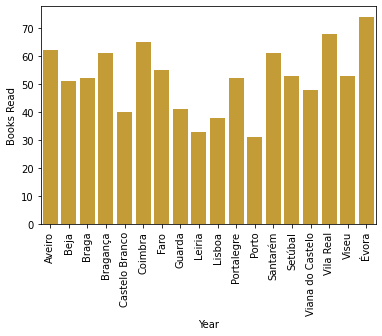

In [59]:

fig = Figure()
ax = fig.subplots()
d = df[df.year==2015]
sns.barplot(x=d['city'],
            y=d['N'], color='goldenrod', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Books Read')
#st.pyplot(fig)
ax.tick_params(axis='x', rotation=90)
fig

In [10]:
df = d_.groupby(['main_tag', 'tag']).size().reset_index(name='N')

In [11]:
df[df['main_tag'] == 'edicoes'].sort_values(by=['N'], ascending=False).head(50)

,main_tag,tag,N
299,edicoes,PERGUNTAS E RESPOSTAS,5
303,edicoes,SINGULAR,3
296,edicoes,CRÍTICA,2
298,edicoes,ENOTURISMO,2
302,edicoes,REVISTA SOLO,2
295,edicoes,BARES,1
297,edicoes,CURIOSIDADE,1
300,edicoes,PSUPERIOR,1
301,edicoes,REPORTAGEM PASSEIOS,1


In [12]:
tags = ['sociedade', 'local', 'fugas', 'politica', 'desporto', 'p3', 'culturaipsilon', 'economia', 'ciencia', 'tecnologia', 'ecosfera']

tags_to_split = ['sociedade', 'local', 'p3']

tags_rename = {'fugas': 'Turismo/Lazer', 
    'desporto': 'Desporto',
    'politica': 'Politica',
    'economia': 'Economia',
    'ciencia': 'Ciencia',
    'culturaipsilon': 'Cultura',
    'tecnologia' : 'Tecnologia',
    'ecosfera': 'Ambiente',
}

sub_tags = {
    'Saude': ['SAÚDE', 'CORONAVÍRUS', 'COVID-19', 'HOSPITAIS', 'SERVIÇO NACIONAL DE SAÚDE', 'NATALIDADE', 'ASAE', 'INEM'],
    'Ambiente': ['METEOROLOGIA', 'MAU TEMPO', 'CLIMA', 'IPMA', 'AMBIENTE', 'ÁGUA', 'SUSTENTABILIDADE', 'FLORESTAS'],
    'Incendios': ['INCÊNDIOS', 'INCÊNDIO','INCÊNDIOS FLORESTAIS'],
    'Forças-Segurança': ['GNR', 'POLÍCIA JUDICIÁRIA', 'PROTECÇÃO CIVIL', 'PSP', 'SERVIÇO DE ESTRANGEIROS E FRONTEIRAS', 'BOMBEIROS'],
    'Educacao': ['ENSINO SUPERIOR', 'EDUCAÇÃO'],
    'Justica' : ['JUSTIÇA', 'MINISTÉRIO PÚBLICO'],
    'Religiao': ['IGREJA CATÓLICA', 'RELIGIÃO'],
    'Crime': ['CRIME', 'VIOLÊNCIA DOMÉSTICA', 'PRISÕES', 'TRÁFICO DE SERES HUMANOS', 'TRÁFICO DE DROGA'],
    'Acidentes' : ['ACIDENTES', 'SEGURANÇA RODOVIÁRIA', 'ESTRADAS'],
    'Transportes' : ['TRANSPORTES', 'COMBOIOS', 'MOBILIDADE', 'BICICLETAS', 'CP', 'MOBILIDADE', 'AVIAÇÃO'],
    'Local' : [
        'LISBOA', 'COIMBRA', 'AVEIRO', 'SETÚBAL', 'VIANA DO CASTELO', 'PORTO', 'BRAGANÇA', 'BRAGA', 'BEJA', 'VISEU', 'ÉVORA',
        'CÂMARA DE VISEU', 'CÂMARA DE LISBOA', 'VILA REAL', 'ALGARVE', 'LEIRIA', 'CASTELO BRANCO', 'FARO', 'SANTARÉM', 'ALENTEJO',
        'CÂMARA DO PORTO', 'PORTALEGRE', 'CÂMARA DE COIMBRA', 'CÂMARA DE BRAGA', 'GUARDA', 'AUTARQUIAS'
    ],
    'Habitacao' : ['HABITAÇÃO', 'PATRIMÓNIO'],
    'Cultura': ['ARTES', 'MÚSICA', 'CULTURA', 'FESTIVAL', 'EVENTO', 'ARTE URBANA', 'STREET ART', 'TEATRO', 'MUSEUS'],
    'Tecnologia': ['TECNOLOGIA'],
    'Opiniao': ['OPINIÃO', 'REPORTAGEM'],
    'Turismo/Lazer': ['TURISMO'],
    'Sociedade': ['CRIANÇAS', 'SOLIDARIEDADE', 'CIGANOS', 'SEGURANÇA SOCIAL', 'IDOSOS', 'ANIMAIS']
}

In [13]:
data_ = d_[d_['main_tag'].isin(tags)]
data_.shape

(11117, 7)

In [14]:
data_to_split = data_[data_['main_tag'].isin(tags_to_split)]
print(data_to_split.shape)
data_not_to_split = data_[~data_['main_tag'].isin(tags_to_split)]
print(data_not_to_split.shape)

(7025, 7)
(4092, 7)


In [15]:
def assign_category(val, sub_tags):
    for key, values in sub_tags.items():
        if val in values:
            return(key)
    return 'Outros'
    

In [16]:
data_to_split['category'] = data_to_split['tag'].apply(lambda val: assign_category(val, sub_tags))

/tmp/ipykernel_9606/712822739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_split['category'] = data_to_split['tag'].apply(lambda val: assign_category(val, sub_tags))


In [17]:
data_to_split['category'].value_counts()

Outros              1977
Local               1414
Ambiente             741
Saude                580
Incendios            349
Crime                284
Acidentes            245
Transportes          207
Justica              196
Forças-Segurança     195
Cultura              185
Educacao             184
Sociedade            126
Opiniao              112
Habitacao            111
Religiao              61
Turismo/Lazer         48
Tecnologia            10
Name: category, dtype: int64

In [18]:
# Apply Renaming
data_not_to_split['category'] = data_not_to_split['main_tag'].apply(lambda val: tags_rename[val])

/tmp/ipykernel_9606/51685350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_not_to_split['category'] = data_not_to_split['main_tag'].apply(lambda val: tags_rename[val])


In [19]:
data_not_to_split['category'].value_counts()

Turismo/Lazer    934
Politica         931
Desporto         789
Cultura          759
Economia         457
Ciencia          165
Tecnologia        32
Ambiente          25
Name: category, dtype: int64

In [20]:
df = pd.concat([data_not_to_split, data_to_split], ignore_index=True)

In [21]:
df.category.value_counts()

Outros              1977
Local               1414
Turismo/Lazer        982
Cultura              944
Politica             931
Desporto             789
Ambiente             766
Saude                580
Economia             457
Incendios            349
Crime                284
Acidentes            245
Transportes          207
Justica              196
Forças-Segurança     195
Educacao             184
Ciencia              165
Sociedade            126
Opiniao              112
Habitacao            111
Religiao              61
Tecnologia            42
Name: category, dtype: int64

In [22]:
from scripts.data_prep import process_stop_words, apply_cleaning

In [23]:
model= spacy.load("pt_core_news_lg")

tc = TextCleaner(model=model, stop_words=process_stop_words())


In [24]:
# from joblib import Parallel, delayed 
# docs = Parallel(n_jobs=2)(delayed(apply_cleaning)(doc, pipeline, tc) for doc in df['title'].to_list()) 

In [24]:
df = df[~df['category'].isin(['Opiniao', 'Outros'])]

In [25]:
df.category.value_counts()

Local               1414
Turismo/Lazer        982
Cultura              944
Politica             931
Desporto             789
Ambiente             766
Saude                580
Economia             457
Incendios            349
Crime                284
Acidentes            245
Transportes          207
Justica              196
Forças-Segurança     195
Educacao             184
Ciencia              165
Sociedade            126
Habitacao            111
Religiao              61
Tecnologia            42
Name: category, dtype: int64

In [27]:
from tqdm import tqdm
df['body'] = [apply_cleaning(doc, tc) for doc in tqdm(df['body'].to_list())]
df['title'] = [apply_cleaning(doc, tc) for doc in tqdm(df['title'].to_list())]
df.to_csv('../data/raw/publico_data_processed.csv.gz', compression='gzip', index=False)

  3%|▎         | 256/9028 [00:15<11:59, 12.19it/s]/home/joao/.cache/pypoetry/virtualenvs/smart_archive-LyPfE8oW-py3.9/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|██████████| 9028/9028 [00:42<00:00, 213.45it/s]


In [25]:
df = pd.read_csv('../data/raw/publico_data_processed.csv.gz', compression='gzip')

In [26]:
X = np.array(df['body'].to_list())
Y = np.array(df['category'].tolist())

NameError: name 'df' is not defined

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
score = []
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, Y ):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    vectorizer = TfidfVectorizer()
    X_train_ = vectorizer.fit_transform(X_train)
    X_test_ = vectorizer.transform(X_test)    

    print('Training classifier')
    svc = linear_model.LogisticRegression()
    svc.fit(X_train_,y_train)

    print('Testing classifier')
    y_pred = svc.predict(X_test_)
    print(classification_report(y_test, y_pred))
    score.append(f1_score(y_test, y_pred, average=None))

print(np.mean(score))

In [ ]:
score = []
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, Y ):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    vectorizer = TfidfVectorizer()
    X_train_ = vectorizer.fit_transform(X_train)
    X_test_ = vectorizer.transform(X_test)    

    print('Training classifier')
    svc = linear_model.SGDClassifier(loss='perceptron', class_weight='balanced')
    svc.fit(X_train_, y_train)

    print('Testing classifier')
    y_pred = svc.predict(X_test_)
    print(classification_report(y_test, y_pred))
    score.append(f1_score(y_test, y_pred, average='macro'))

print(np.mean(score))

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

score = []
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, Y ):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    vectorizer = TfidfVectorizer()
    X_train_ = vectorizer.fit_transform(X_train)
    X_test_ = vectorizer.transform(X_test)    

    print('Training classifier')
    clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train_, y_train)

    print('Testing classifier')
    y_pred = clf.predict(X_test_)
    print(classification_report(y_test, y_pred))
    score.append(f1_score(y_test, y_pred, average='macro'))

print(np.mean(score))

In [44]:
df_train = pd.DataFrame() 
df_train['category'] = y_train
df_train['title'] = X_train
df_train['category'] = df_train['category'].apply(lambda val: f'__label__{val}')

np.savetxt('categories-train.txt', df_train.values, fmt = "%s")

print(df_train.shape)

df_test = pd.DataFrame() 
df_test['category'] = y_test
df_test['title'] = X_test
df_test['category'] = df_test['category'].apply(lambda val: f'__label__{val}')

print(df_test.shape)

(7222, 2)
(1806, 2)


In [45]:
import fasttext
model = fasttext.train_supervised(input="categories-train.txt", lr=1, epoch=100, wordNgrams=5)
df_test['Pred'] = df_test['title'].apply(lambda val: model.predict(val)[0][0])
print(classification_report(df_test['category'], df_test['Pred']))

Read 1M words
Number of words:  86342
Number of labels: 20
Progress: 100.0% words/sec/thread:  156322 lr:  0.000000 avg.loss:  0.105302 ETA:   0h 0m 0s


                           precision    recall  f1-score   support

       __label__Acidentes       0.75      0.78      0.76        49
        __label__Ambiente       0.87      0.88      0.87       153
         __label__Ciencia       0.72      0.70      0.71        33
           __label__Crime       0.64      0.67      0.66        57
         __label__Cultura       0.84      0.92      0.88       189
        __label__Desporto       0.97      0.97      0.97       158
        __label__Economia       0.70      0.82      0.75        92
        __label__Educacao       0.85      0.76      0.80        37
__label__Forças-Segurança       0.63      0.56      0.59        39
       __label__Habitacao       0.55      0.27      0.36        22
       __label__Incendios       0.87      0.87      0.87        70
         __label__Justica       0.55      0.62      0.58        39
           __label__Local       0.70      0.65      0.67       283
        __label__Politica       0.89      0.84      0.86     

## Neural Net (RNN)

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)

n_classes = len(np.unique(y_train))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, to_categorical(le.transform(y_train), num_classes=n_classes)))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, to_categorical(le.transform(y_test), num_classes=n_classes)))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


VOCAB_SIZE = 100000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=100,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True, 
    mode='min'
)

# Hyperparameters
epochs = 10
learning_rate = 0.001
decay_rate = learning_rate / epochs

opt = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    #decay=decay_rate 
    )

model.compile(
    optimizer=opt, 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.metrics.Precision()]
)

2022-04-24 21:11:06.283116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 21:11:06.283134: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


NameError: name 'y_train' is not defined

In [47]:

model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=callback
 )


Epoch 1/10


2022-04-24 20:17:25.024259: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27521200 exceeds 10% of free system memory.
2022-04-24 20:17:25.031985: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27521200 exceeds 10% of free system memory.


113/113 [==============================] - 192s 2s/step - loss: 2.3559 - precision: 0.8448 - val_loss: 1.6142 - val_precision: 0.8859
Epoch 2/10
 84/113 [=====================>........] - ETA: 45s - loss: 1.3420 - precision: 0.8373

In [ ]:
model.evaluate(test_dataset)

In [ ]:
preds = model.predict(test_dataset)
preds = [le.inverse_transform([np.argmax(pred)])[0] for pred in preds]

In [ ]:
print(classification_report(y_test, preds))

## Sentiment


In [47]:
import fasttext
model = fasttext.load_model('../models/trained/fasttext-sentiment.bin')

In [48]:
model.predict(df['title'].iloc[0])[0]

('__label__Positive',)

In [35]:
df['title'].iloc[0]

'quinta avenida seculo xvi ficava lisboa'

In [81]:
sent = []
indexes = []
for i, val in enumerate(df['title'].to_list()):
    try:
        sent.append(model.predict(val.replace('\n', '')))
        indexes.append(i)
    except:
        print(val)
        continue

nan
nan


In [66]:
data_p.iloc[indexes]

,body,title
0,seculo xvi rua nova mercadores pequena babel. ...,quinta avenida seculo xvi ficava lisboa
1,costa fara declaracao quartafeira volta meiodi...,costa deixa camara lisboa concentrar apenas ps
2,concessao equipamento visitados cidade lisboa ...,sociedade francisco manuel santos fica oceanar...
3,frase contexto costa afirmou reduzido divida c...,divida camara lisboa paga governo
4,seculo xvi rua nova mercadores pequena babel. ...,quinta avenida seculo xvi ficava lisboa
...,...,...
9023,numero nascimentos portugal recuperou primeiro...,numero nascimentos recuperou.o trimestre bebes
9024,servico veterinaria municipio pombal detectou ...,gatos morrem pombal doenca altamente contagiosa
9025,manha tercafeira ceu pais ganhou tom alaranjad...,tempestade celia empurra poeira sara portugal
9026,portal agendamento vacina internet deixou aces...,covid portal agendamento vacinacao deixa exist...


In [67]:
results = data_p.iloc[indexes]
results['sentiment'] = [val[0][0] for val in sent]
results['score'] = [val[1][0] for val in sent]

/tmp/ipykernel_5026/4056973279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['sentiment'] = [val[0][0] for val in sent]
/tmp/ipykernel_5026/4056973279.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['score'] = [val[1][0] for val in sent]


In [ ]:
results[['title', 'sentiment']].head(50)

In [ ]:
results.score.hist()

In [ ]:
results[(results.sentiment == '__label__Negative') & (results.score > 0.80)].head(50)

In [31]:
nlp = spacy.load("pt_core_news_lg")

In [ ]:
aspects = []

for sentence in d_.iloc[-1].body.split('.'):
  doc = nlp(sentence)
  descriptive_term = ''
  target = ''
  for token in doc:
    if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
      target = token.text
    if token.pos_ == 'ADJ':
      prepend = ''
      for child in token.children:
        if child.pos_ != 'ADV':
          continue
        prepend += child.text + ' '
      descriptive_term = prepend + token.text
  if target and descriptive_term:    
    aspects.append({'aspect': target,
      'description': descriptive_term, 'sentence': sentence})
print(aspects)

In [29]:
for sentence in d_.iloc[-2].body.split('.'):
  doc = nlp(sentence)
  for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
      token.pos_,[child for child in token.children])

AttributeError: 'float' object has no attribute 'split'

In [ ]:
for sentence in data_p.iloc[-4].body.split('.'):
  doc = nlp(sentence)
  descriptive_term = ''
  for token in doc:
    if token.pos_ == 'ADJ':
      descriptive_term = token
      print(sentence)
      print(token.text)
      print(model.predict(sentence.replace('\n', '')))
  #print(sentence)
  #print(descriptive_term)

In [37]:
for sentence in data_p.iloc[-3].body.split('.'):
  doc = nlp(sentence)
  descriptive_term = ''
  for token in doc:
    if token.pos_ == 'ADJ':
      prepend = ''
      for child in token.children:
        if child.pos_ != 'ADV':
          continue
        prepend += child.text + ' '
      descriptive_term = prepend + token.text

  if descriptive_term:
    print(sentence)
    print('TerM:', descriptive_term)
    print('Sentiment:', model.predict(descriptive_term))


manha tercafeira ceu pais ganhou tom alaranjado estranho poeiras sara volta portugal empurradas tempestade celia
TerM: estranho
Sentiment: (('__label__Negative',), array([0.5325433]))
 ventos fortes levantam poeira deserto sara pode subir tres metros altitude
TerM: tres
Sentiment: (('__label__Positive',), array([0.94151944]))
 tempestade celia ajudou poeira deslocarse continente europeu
TerM: europeu
Sentiment: (('__label__Neutral',), array([1.00001001]))
 ocorrer transporte poeiras territorio continental devido fluxo sul induzido depressao celia
TerM: sul
Sentiment: (('__label__Positive',), array([1.00000882]))
 poeiras suspensao oriundas norte africa atingiram peninsula iberica  lese comunicado site instituto portugues mar atmosfera ipma
TerM: ipma
Sentiment: (('__label__Negative',), array([0.98088437]))
 ipma explica sitios maior concentracao poeiras poderao registarse mudancas qualidade ar impactos saude
TerM: maior
Sentiment: (('__label__Positive',), array([1.00000978]))
 problema

In [ ]:
d_.iloc[0].body.split('.')

In [23]:
model.predict('diminuir')

(('__label__Positive',), array([1.00001001]))

In [38]:
data_p

,body,title
0,seculo xvi rua nova mercadores pequena babel. ...,quinta avenida seculo xvi ficava lisboa
1,costa fara declaracao quartafeira volta meiodi...,costa deixa camara lisboa concentrar apenas ps
2,concessao equipamento visitados cidade lisboa ...,sociedade francisco manuel santos fica oceanar...
3,frase contexto costa afirmou reduzido divida c...,divida camara lisboa paga governo
4,seculo xvi rua nova mercadores pequena babel. ...,quinta avenida seculo xvi ficava lisboa
...,...,...
9023,numero nascimentos portugal recuperou primeiro...,numero nascimentos recuperou.o trimestre bebes
9024,servico veterinaria municipio pombal detectou ...,gatos morrem pombal doenca altamente contagiosa
9025,manha tercafeira ceu pais ganhou tom alaranjad...,tempestade celia empurra poeira sara portugal
9026,portal agendamento vacina internet deixou aces...,covid portal agendamento vacinacao deixa exist...
